# Training Models

* Closed form or Gradient Descent (Stochastic, Batch, Mini-Batch)

## Linear Regression
### Representation 
$\hat{y} = \theta^{T}\cdot x$
* Represent one instance of a prediction (an $x_i$)
* $x$ is feature vector - $x_0$ always is (1) - for constants
* $\hat{y}$ is prediction (1 value)
* $\theta^{T}$ is parameter vector. Transposed to dot because ML usually represents as column vector

### Error
$\text{MSE}(\theta) = 1/m\sum_{i=1}^{m}(\theta^Tx^i - y^i)^2$
* Diff predicted value to real value for all points (squared for non-negs)

### Closed Form Equation
Find the parameter vector that minimize MSE --- $\hat{\theta}$

$\hat{\theta} = (X^TX)^\text{-1}X^Ty$

* $X$ is matrix with row = data point, col = features
* $y$ is vector of $y_1$ to $y_m$ (1D array with m values)
* Runtime
    * $O(n^3)$ - n being number of features -- because Inverse of $X \cdot X^T$ is $O(n^3)$
    * Scales linearly with number of samples

### Trying it out
* Using GDP vs Hapiness data downloaded and processed in (datasets/gdp-happiness)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Using Closed Form

In [2]:
gdp_happiness = pd.read_csv("datasets/gdp-happiness/gdp-vs-happiness-2017.csv")
gdp_happiness.columns

Index(['Country', 'GDP Per Capita', 'Life Satisfaction'], dtype='object')

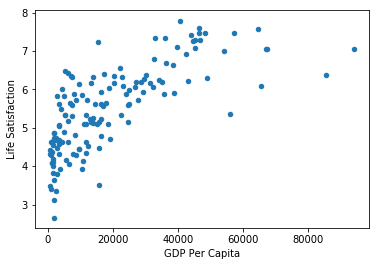

In [3]:
gdp_happiness.plot.scatter(x="GDP Per Capita", y="Life Satisfaction")

In [4]:
# Implements the closed form
def theta_best(X,y): 
    X_t = X.T
    return np.linalg.inv(X_t.dot(X)).dot(X_t).dot(y)

In [5]:
# .values to get numpy array out of pandas series
# np.c_ ~= zip

# Note: needs to add 1 to a feature for constant to show up in theta

X_gdp = np.c_[
    np.ones(gdp_happiness["GDP Per Capita"].values.size),
    gdp_happiness["GDP Per Capita"].values
]

theta_gdp_happiness = theta_best(X_gdp, gdp_happiness["Life Satisfaction"].values)

In [6]:
theta_gdp_happiness

array([4.66027944e+00, 4.31820655e-05])

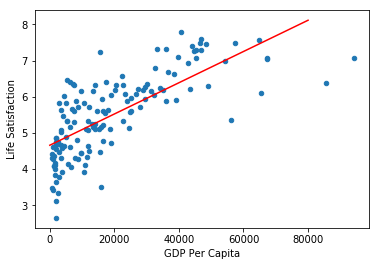

In [7]:
gdp_happiness.plot.scatter(x="GDP Per Capita", y="Life Satisfaction")
x_lin = np.linspace(0, 80000, 1000)
y_lin = theta_gdp_happiness[0] + theta_gdp_happiness[1]*x_lin
plt.plot(x_lin, y_lin, "-r")

### Using Scikit-Learn

In [8]:
# .reshape(-1,1) to make an array 2D -- even when we only have 1 feature
# Edited: can easily obtain column vector from pandas df[["col"]] rather than df["col"]

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(gdp_happiness[["GDP Per Capita"]], gdp_happiness[["Life Satisfaction"]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
lin_reg.intercept_, lin_reg.coef_

(array([4.66027944]), array([[4.31820655e-05]]))

## Gradient Descent
### Steps
1. Fill $\theta$ with random value
2. Take a small step (learning rate) in a direction that lower $\text{MSE}$
   * Too small -- takes long time
   * Too large -- overshoot to other side of curve
   * Many stuck in local minimum

Linear regression is convex, so there's only one local minimum, which is the global minimum

__It is important to scale the features for gradient descent to work well__

### Batch Gradient Descent
For each parameter $\theta_j$, take partial derivative at $j$ to find the slope for each $j$. 

$\frac{\partial}{\partial \theta_j}\text{MSE}(\theta) = 2/m\sum_{i=1}^{m}(\theta^Tx^i - y^i)x^i_j$

Combining all $\theta_j$ together in one vector $\nabla_\theta\text{MSE}(\theta)$ represents partial derivative of all $\theta_j$

$\nabla_\theta\text{MSE}(\theta) = \frac{2}{m}X^T(X\theta - y)$
* $X$ is the entire training data set
* $\theta$ is the current parameter vector
* Note that we compute the whole data set every time

$\nabla_\theta\text{MSE}(\theta)$ represents a slope. We would like update the value by walking down (opposite) the slope at step size (or learning rate or eta sign) = $\eta$

$\theta_\text{next} = \theta - \eta*\nabla_\theta\text{MSE}(\theta)$

In [10]:
# From the warnings, lets scale X_gdp first
from sklearn.preprocessing import StandardScaler
Xscaler = StandardScaler()
X_gdp_scaled = np.c_[
    np.ones(gdp_happiness["GDP Per Capita"].values.size),
    Xscaler.fit_transform(gdp_happiness[["GDP Per Capita"]])
]

(Xscaler.mean_, Xscaler.scale_)

(array([19232.53960348]), array([18724.37121949]))

In [11]:
# Then scale y
yScaler = StandardScaler()
y_gdp_scaled = yScaler.fit_transform(gdp_happiness[["Life Satisfaction"]])

(yScaler.mean_, yScaler.scale_)

(array([5.49078023]), array([1.1127658]))

In [12]:
# Implements Batch Gradient Descent for linear regression

def update_theta(theta, eta, gradient):
    return theta - eta * gradient

def find_gradient(theta, X, y):
    m = X.size
    return 2/m * X.T.dot( X.dot(theta) - y )

def bgd(X,y,initialTheta, eta=0.1, rounds=100):
    theta = initialTheta
    for i in range(rounds):
        gradient = find_gradient(theta, X, y)
        theta = update_theta(theta, eta, gradient)
        
    return theta

bgd(X_gdp_scaled, y_gdp_scaled, [[0],[0]])

array([[-5.66757208e-17],
       [ 7.26599927e-01]])

In [205]:
# Compared it with scaled linear regression

from sklearn.linear_model import LinearRegression
lin_reg_gdp_scaled = LinearRegression()
lin_reg_gdp_scaled.fit(X_gdp_scaled[:,1].reshape(-1,1), y_gdp_scaled)

lin_reg_gdp_scaled.intercept_, lin_reg_gdp_scaled.coef_

(array([-5.78764824e-17]), array([[0.72661923]]))

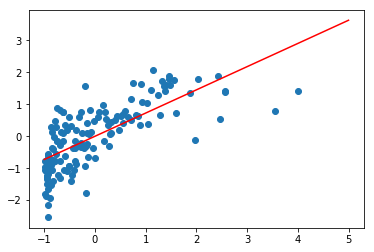

In [206]:
# Plot the scaled
plt.scatter(X_gdp_scaled[:,1], y_gdp_scaled)
x_lin = np.linspace(-1,5, 100)
y_lin = lin_reg_gdp_scaled.predict(x_lin.reshape(-1,1))
plt.plot(x_lin, y_lin, "-r")

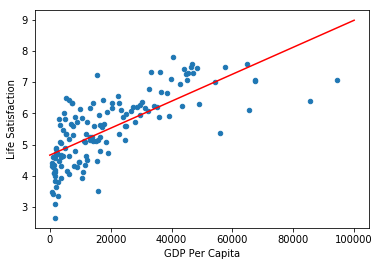

In [207]:
# Bonus - unscaled the values using scaler.inverse_transform
gdp_happiness.plot.scatter(x="GDP Per Capita", y="Life Satisfaction")
x_lin = np.linspace(0,100000, 100)

# This is rather tedious, find a better way?
y_lin = yScaler.inverse_transform( lin_reg_gdp_scaled.predict(Xscaler.transform(x_lin.reshape(-1,1))) )
plt.plot(x_lin, y_lin, "-r")

## Stochasic Gradient Descent
* Pick only one point of data at random, and use it to train (rather than whole set of data)
* Suitable to have a large initial learning rate then smaller (simulated annealing, learning schedule)
* Much less regular, cost will bump up and down - may be suitable to jump out of local minima
* random m times in 1 round (called __epoch__)

Note
* Training instance must be independent (not groupped). shuffle if needed

### Try it out

In [278]:
# t0, t1 is learning schedule hyper parameters
def learning_schedule(t, t0=7, t1=1):
    return t0 / (t + t1)

def sgd(X,y, initial_theta, epochs=200):
    m = X.shape[0]
    theta = initial_theta
    errors = []
    for epoch in range(epochs):
        for i in range(m):
            idx = np.random.randint(m)
            xi = X[idx:idx+1] # Use ranges, so we got a 2D vector instead of 1D (array)
            yi = y[idx:idx+1]
            gradients = find_gradient(theta, xi, yi) # same as batch, but only 1 element here
            eta = learning_schedule(epoch * m + i)
            theta = update_theta(theta,eta,gradients)

        # Error at end of epoch
        errors.append( np.sum((X.dot(theta) - y)**2) ) 
            
    return theta, errors
    
sgd_theta, errors = sgd(X_gdp_scaled, y_gdp_scaled, [[0],[0]])
sgd_theta

array([[0.00524856],
       [0.73889146]])

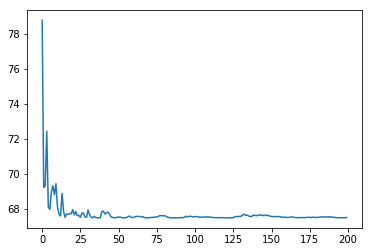

In [279]:
# Errors jumps around for SGD
plt.plot(errors)

### Using Scikit Learn

In [297]:
#.ravel ~= flatmap [ [0],[1] ] -> [0,1]
# transform from column vector to array

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.01)
sgd_reg.fit(X_gdp_scaled[:,1].reshape(-1,1), y_gdp_scaled.ravel())


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [298]:
sgd_reg.intercept_, sgd_reg.coef_

(array([-0.000493]), array([0.70833334]))

In [299]:
## Mini batch ?? - https://github.com/ageron/handson-ml/issues/226